# Chess Piece Detection

### AIM: To recognise the chess pieces using OpenCV and Keras

In [1]:
# Imports

import cv2
import time
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from mpl_toolkits.axes_grid1 import ImageGrid

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


### Chessboard detection

#### Accessing the camera using OpenCV and clicking an image

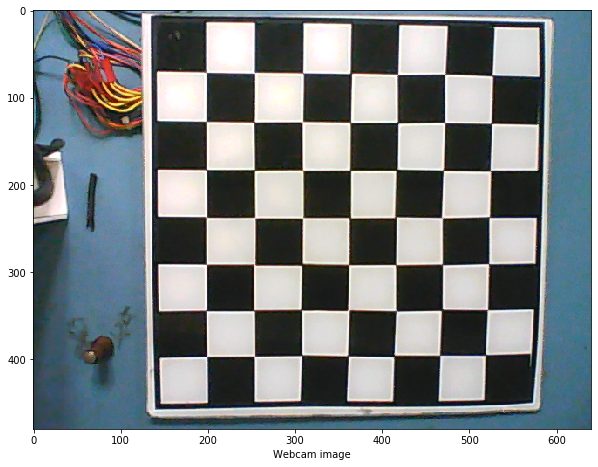

In [2]:
# Accessing the camera

cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    frame = cv2.flip(frame, 1)
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()


plt.figure(figsize=(10, 10))
plt.xlabel('Webcam image')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

#### Converting the image to grayscale, finding contours and drawing them.

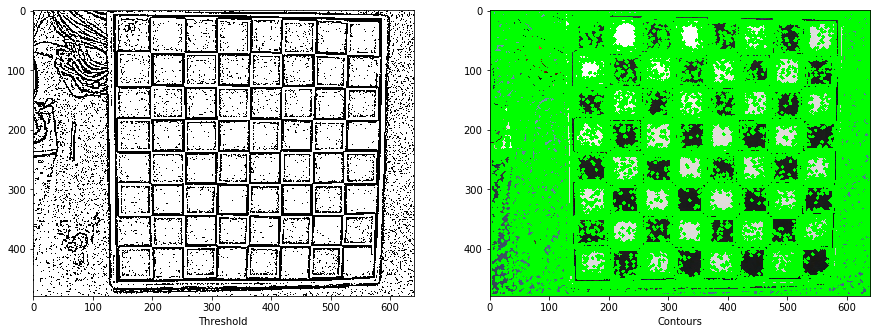

In [3]:
# Converting image into grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Converts a grayscale image to binary image
threshold_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Finding the contours of the chessboard
contours, _ = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Drawing the contours on the chessboard
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

# Plotting the image
plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.imshow(threshold_image, cmap='gray')
plt.xlabel('Threshold')

plt.subplot(1, 2, 2)
plt.imshow(contour_image)
plt.xlabel('Contours')

plt.show()

#### Finding the chessboard

In [4]:
# Finding the board (region of interest) in the image

def find_board_contour(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    hierarchy = hierarchy[0]
    children = []

    for i in range(len(contours)):
        epsilon = 0.1 * cv2.arcLength(contours[i],True)
        approx = cv2.approxPolyDP(contours[i], epsilon, True)  
        area = cv2.contourArea(approx)
        if len(approx) == 4 and area > 500:
            children.append(hierarchy[i])

    children = np.array(children)
    values,counts = np.unique(children[:, 3], return_counts=True)
    contour = contours[values[np.argmax(counts)]]
    epsilon = 0.1 * cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, epsilon, True) 

#### Change the perspective to the board image

In [5]:
# Changing the perspective from the entire image to the board image
def correct_perspective(img, approx):                                                      
    pts = approx.reshape(4, 2)      
    tl, tr, br, bl =  (
        pts[np.argmin(np.sum(pts, axis=1))],
        pts[np.argmin(np.diff(pts, axis=1))],   
        pts[np.argmax(np.sum(pts, axis=1))],                           
        pts[np.argmax(np.diff(pts, axis=1))]
    )

    w = max(np.linalg.norm(br-bl), np.linalg.norm(tr-tl))
    h = max(np.linalg.norm(tr-br), np.linalg.norm(tl-bl))

    src = np.array([tl, tr, br, bl], dtype='float32')
    dst = np.array([[0, 0],[w, 0],[w, h],[0, h]], dtype='float32')                                        

    M = cv2.getPerspectiveTransform(src, dst)
    img = cv2.warpPerspective(img, M, (int(w), int(h)))

    return cv2.resize(img, (400,400))

#### Drawing contours on the border of the chessboard

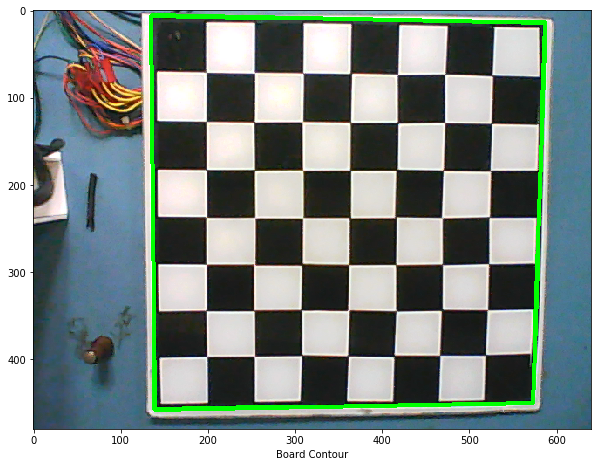

In [6]:
# Drawing the border on the chessboard

approx = find_board_contour(frame)

contour_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).copy()
cv2.drawContours(contour_image, [approx], -1, (0, 255, 0), 3)

plt.figure(figsize=(10, 10))
plt.xlabel('Board Contour')
plt.imshow(contour_image)
plt.show()

#### Displaying the extracted image

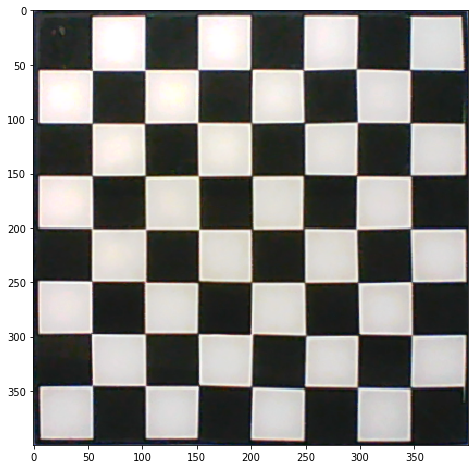

In [7]:
plt.figure(figsize=(8, 8))

board = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).copy()
board = correct_perspective(board, approx)
plt.imshow(board)
plt.show()

#### Extracting each square from the chessboard

In [16]:
# Extracting each square from the chessboard
def get_square(img, row, col):
    width = img.shape[0]
    square = width // 8
    x1, y1 = row * square, col * square
    x2, y2 = x1 + square, y1 + square
    return img[x1:x2, y1:y2]

#### Displaying the image with segregated squares

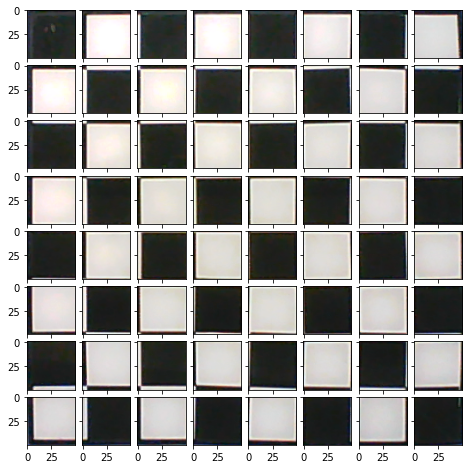

In [22]:
fig = plt.figure(1, (8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0.1)

# board = dewarp(image, approx)
board = cv2.resize(board, (400, 400))

for i in range(8*8):
    col = i % 8
    row = i // 8
    square = get_square(board, row, col)
    # grid[i].imshow(cv2.cvtColor(square, cv2.COLOR_BGR2RGB))
    grid[i].imshow(square)

plt.show()

#### Creating the dataset
###### (Not running this since I already created the dataset)

In [ ]:
# Setting the path and the labels.
train_path = './train_data/images'
label_map = list('KQRBNP_kqrbnp')

# Initializing the camera
capture = cv2.VideoCapture(0)

# Setting the height and the width
capture.set(3, 1280)
capture.set(4, 720)

if not capture.isOpened():
    raise RuntimeError('Failed to start camera.')

quit = False
ret, img = capture.read()
approx = find_board_contour(img)

In [ ]:
# Creating the dataset

for piece in label_map:
    if quit: break
    path = os.path.join(train_path, piece)
    if not os.path.exists(path):
        os.mkdir(path)
                
    for i in range(8 * 8):
        if quit: break
            
        while True:
            ret, img = capture.read()
            board = correct_perspective(img, approx)
            col = i % 8
            row = i // 8
            square = get_square(board, row, col)
            key_press = cv2.waitKey(5)

            if key_press & 0xFF == ord(' '):
                file_name = '{}_{}.jpg'.format(piece, time.time())
                cv2.imwrite(os.path.join(path, file_name), square)
                break
            
            if key_press & 0xFF == ord('q'):
                quit = True
                break

            width = board.shape[0]
            s = width // 8
            x1, y1 = col * s, row * s
            x2, y2 = x1 + s, y1 + s
            cv2.rectangle(board , (x1, y1), (x2, y2) ,(0, 255, 0), 3)
            cv2.imshow('Capturing piece: {}'.format(piece), board)


cv2.destroyAllWindows()
capture.release()

In [ ]:
# Rotating the image to increase the dataset
def rotate(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [ ]:
# Creating the images
images = glob.glob('/train_data/images/*/*.jpg')

for f in images:
    file_name = os.path.basename(f)
    dir_name = os.path.dirname(f)
    img = cv2.imread(f)
    for i in range(1, 4):
        new_img = rotate(img, i * 90)
        new_name = '{}_{}{}'.format(file_name[0],(i * 90),file_name[1:])
        new_path = os.path.join(dir_name, new_name)
        cv2.imwrite(new_path, new_img)

img = cv2.imread('./train_data/images/P/P_1573125920.6008694.jpg')
plt.imshow(img)
plt.show()

#### Resizing the image and exporting it to .csv

In [23]:
img_size = (50, 50)
label_map = list('KQRBNP_kqrbnp')
num_classes = len(label_map)


images = glob.glob('./train_data/images/*/*.jpg')

data_rows = []
for f in images:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size).flatten()
    label = label_map.index(os.path.basename(f)[0])
    data_rows.append(np.insert(img, 0, label))


train_data = pd.DataFrame(data_rows)
print(train_data.head())

train_data.to_csv('./train_data/train_data.csv', index=False)

   0     1     2     3     4     5     6     7     8     9     ...  2491  \
0     3   221   220   225   232   233   234   234   236   239  ...   117   
1     3   249   249   247   247   250   250   250   251   248  ...    41   
2     3   253   254   254   253   252   253   253   253   252  ...   158   
3     3   247   246   247   248   246   246   247   248   247  ...    43   
4     3   238   238   238   240   240   238   237   239   241  ...   209   

   2492  2493  2494  2495  2496  2497  2498  2499  2500  
0   117   117   118   119   117   140   166   187   208  
1    41    43    44    46    47    47    53    50    49  
2   155   157   163   174   189   203   216   232   252  
3    44    49    51    56    57    56    49    56   122  
4   218   222   224   225   240   252   216   102    35  

[5 rows x 2501 columns]


##### Reading the file if already created (Not necessary)

In [24]:
train_data = pd.read_csv('./train_data/train_data.csv', skiprows=1, header=None)

#### Viewing the created image from csv

Label: q


c:\users\pm0c82480\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


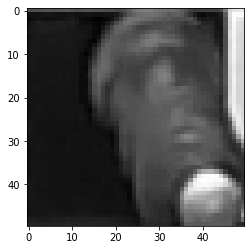

In [25]:
# Reading the created images
first_row = train_data.sample(n=1)
label = label_map[first_row[0].item()]
img = first_row.drop([0], axis=1).values
plt.imshow(img.reshape(50,50), cmap='gray')
print('Label: {}'.format(label))
plt.show()

#### Spliting the data into training and test set and resizing the image

In [26]:
# Train and test set split
input_shape = (*img_size, 1)
X = train_data.drop([0], axis=1).values
y = to_categorical(train_data[0].values)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], *img_size, 1)
X_val = X_val.reshape(X_val.shape[0], *img_size, 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

X_train /= 255
X_val /= 255

pool_size=(4,4)

#### Creating a CNN model

In [27]:
# Creating a CNN model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

#### Training the model and saving it for later usage

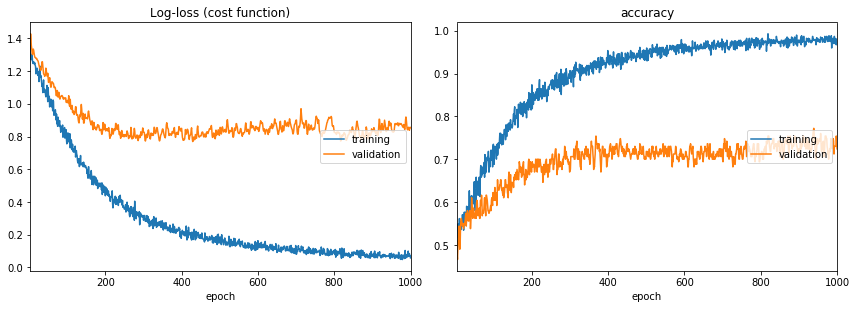

Log-loss (cost function):
training   (min:    0.048, max:    1.391, cur:    0.058)
validation (min:    0.769, max:    1.428, cur:    0.855)

accuracy:
training   (min:    0.477, max:    0.992, cur:    0.980)
validation (min:    0.467, max:    0.772, cur:    0.725)


In [39]:
# Training the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=512, epochs=1000, callbacks=[PlotLossesKeras()], verbose=0, validation_data=(X_val, y_val))

# print("Accuracy:", hist.history['val_acc'][-1])

# Saving the model
model.save('./train_data/chess_model.hd5')

#### Loading the saved model

In [40]:
# Loading the model
from keras.models import load_model
model = load_model('./train_data/chess_model.hd5')

def predict(img, model, img_size=(50,50), plot=False):
    img = cv2.resize(img, img_size) 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )

    if plot:
        plt.imshow(img, cmap='gray')

    img = img.reshape(1, *img_size, 1) / 255
    pred = model.predict(img)
    return label_map[np.argmax(pred)]

#### Predicting the output image

The image is a White Knight


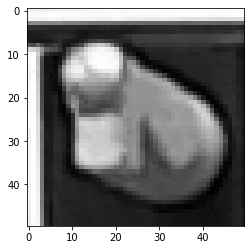

In [41]:
path = './train_data/images/N/N_1573125624.500183.jpg'
name_map = {
    'K':'White King',
    'Q':'White Queen',
    'R':'White Rook',
    'B':'White Bishop',
    'N':'White Knight',
    'P':'White Pawn',
    '_':'Empty Square',
    'k':'Black King',
    'q':'Black Queen',
    'r':'Black Rook',
    'b':'Black Bishop',
    'n':'Black Knight',
    'p':'Black Pawn',
}

img = cv2.imread(path)
pred = predict(img, model, plot=True)
print('The image is a', name_map[pred])

### References

GUI features
https://docs.opencv.org/master/dc/d4d/tutorial_py_table_of_contents_gui.html

Camera caliberation
https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html

Image processing
https://docs.opencv.org/master/d2/d96/tutorial_py_table_of_contents_imgproc.html

Object detection
https://docs.opencv.org/master/d2/d64/tutorial_table_of_content_objdetect.html

Sequential model
https://keras.io/getting-started/sequential-model-guide/

Sequential model methods (fit, compile, evaluate, predict)
https://keras.io/models/sequential/

CNN layers -

1. Convolution layer 
https://docs.opencv.org/master/dc/d4d/tutorial_py_table_of_contents_gui.html

2. Pooling layer
https://keras.io/layers/pooling/

3. Core layers (Dropout, Flatten, Dense)
https://keras.io/layers/core/

Loss functions
https://keras.io/losses/

Performance metrics
https://keras.io/metrics/